In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [1]:
from utils.metrics import *
from utils.losses import *

import os
import pandas as pd
import warnings
import numpy as np
from skimage import io, transform
from rasterio.features import rasterize
from shapely.ops import cascaded_union, unary_union
from shapely.geometry import Polygon
from shapely.errors import ShapelyDeprecationWarning
from torch.utils.data import Dataset
import pickle
import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
from pytorch_metric_learning import losses
import copy

from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import timm
from torch.cuda import amp
from tqdm import tqdm
import torch.optim as optim
from time import time

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore")

c:\Users\Yoga 6 R5\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check file or directory is exist
train_df = pd.read_csv('ForestNetDataset/train_new.csv')
val_df = pd.read_csv('ForestNetDataset/val_new.csv')
test_df = pd.read_csv('ForestNetDataset/test_new.csv')

train_df.head()

,label,merged_label,latitude,longitude,year,example_path
0,Grassland shrubland,Grassland shrubland,-1.720266,115.006996,2016,-1.720266384577504_115.00699582064485
1,Grassland shrubland,Grassland shrubland,-2.709149,113.340780,2016,-2.7091489238834305_113.3407801546713
2,Timber plantation,Plantation,-0.652245,109.920619,2012,-0.6522445100247509_109.9206187702712
3,Oil palm plantation,Plantation,-1.347868,110.527867,2014,-1.3478682873694396_110.52786683455288
4,Grassland shrubland,Grassland shrubland,-2.885256,111.584100,2016,-2.8852555512190485_111.5840999668356


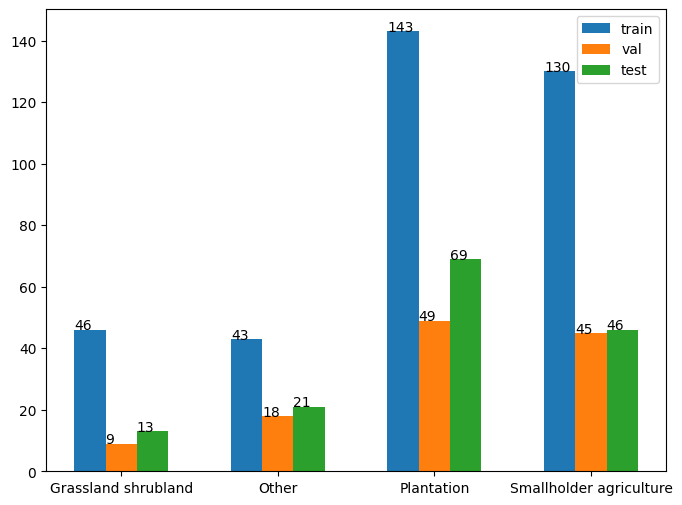

In [3]:
# Plot distribution of data
train_df_class = train_df.groupby(['merged_label']).size().to_frame('train').reset_index()
val_df_class = val_df.groupby(['merged_label']).size().to_frame('val').reset_index()
test_df_class = test_df.groupby(['merged_label']).size().to_frame('test').reset_index()

plt.figure(figsize=(8, 6))
x_axis = np.arange(len(train_df_class['merged_label']))
index = [[train_df_class,'train',-0.2],[val_df_class,'val',0],[test_df_class,'test',0.2]]
for i in index:
  df = i[0]
  bars = plt.bar(x_axis + i[2], df[i[1]] , width=0.2, label=i[1])
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x(), yval + .005, yval)
plt.xticks(x_axis,train_df_class['merged_label'])
plt.legend()
plt.show()

### Updated ForestNet class

In [90]:
from torch.utils.data import Dataset
import torch
import numpy as np
import os
from skimage import io
from rasterio.features import rasterize
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
import pickle


class ForestDataset(Dataset):
    """Forest dataset."""

    def __init__(
        self,
        csv_file_to_df,
        root_dir="ForestNetDataset",
        transform=None,
        types="classifier",
    ):
        self.csv = csv_file_to_df
        self.root_dir = root_dir
        self.transform = transform
        self.label_to_int = {
            "Grassland shrubland": 0,
            "Other": 1,
            "Plantation": 2,
            "Smallholder agriculture": 3,
        }
        self.types = types

    def __len__(self):
        return len(self.csv)

    def poly_from_utm(self, polygon):
        poly_pts = []
        if isinstance(polygon, Polygon):
            for i in np.array(polygon.exterior.coords):
                poly_pts.append(tuple(i))
        elif isinstance(polygon, MultiPolygon):
            for p in polygon.geoms:
                for i in np.array(p.exterior.coords):
                    poly_pts.append(tuple(i))
        else:
            raise ValueError(f"Unsupported geometry type: {type(polygon)}")
        return Polygon(poly_pts)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.csv.iloc[idx, 0]
        merged_label = self.csv.iloc[idx, 1]
        lat = self.csv.iloc[idx, 2]
        long = self.csv.iloc[idx, 3]
        year = self.csv.iloc[idx, 4]
        folder = self.csv.iloc[idx, 5]

        ## Load the image and auxiliary
        image_path = os.path.join(
            self.root_dir, "examples", folder, "images", "visible", "composite.png"
        )
        slope_path = os.path.join(
            self.root_dir, "examples", folder, "auxiliary", "srtm.npy"
        )
        forest_loss_path = os.path.join(
            self.root_dir, "examples", folder, "forest_loss_region.pkl"
        )

        image = io.imread(image_path)
        slope = np.load(slope_path)

        ## Get the segmentation map
        with open(forest_loss_path, "rb") as f:
            data = pickle.load(f)

        nx, ny = 332, 332
        xy_array = np.empty((0, 2))

        if isinstance(data, (Polygon, MultiPolygon)):
            poly_shp = [self.poly_from_utm(data)]
        else:
            poly_shp = [self.poly_from_utm(poly) for poly in data]

        mask = rasterize(shapes=poly_shp, out_shape=(332, 332))
        seg = np.array(mask)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        image = torch.from_numpy(image).type(torch.float)
        image = image.permute(2, 0, 1)
        seg = torch.from_numpy(seg).type(torch.uint8)
        slope = torch.from_numpy(slope).type(torch.float)

        merged_label = self.label_to_int[merged_label]

        image = image[:, 86:246, 86:246]
        seg = seg[86:246, 86:246]
        slope = slope[1]
        slope = slope[86:246, 86:246]
        if self.types == "classifier":
            return image, seg, slope, merged_label
        else:
            return image, seg, merged_label

In [91]:
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Rotate(270),
        A.ElasticTransform(
            p=0.4, alpha=120, sigma=120 * 0.05, alpha_affine=None
        ),
    ]
)

In [92]:
# Initialization several arguments for training
BATCH_SIZE = 16
DEVICE = device = "cuda:0" if torch.cuda.is_available() else "cpu"
LR = 0.001
EPOCH = 20
nbClass = 4

In [93]:
# Load Dataset and Create DataLoader For Classification
train_dataset = ForestDataset( csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset( csv_file_to_df=val_df)
test_dataset = ForestDataset( csv_file_to_df=test_df)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}

# Load Dataset and Create DataLoader For Representation Learning
train_dataset_re = ForestDataset( csv_file_to_df=train_df, transform=transform, types="projection")
val_dataset_re = ForestDataset( csv_file_to_df=val_df, types="projection")
test_dataset_re = ForestDataset( csv_file_to_df=test_df, types="projection")
trainloader_re = torch.utils.data.DataLoader(train_dataset_re, batch_size=BATCH_SIZE,shuffle=True)
valloader_re = torch.utils.data.DataLoader(val_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
testloader_re = torch.utils.data.DataLoader(test_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
dataloaders_re = {'train': trainloader_re, 'val':valloader_re}

In [95]:
dataiter = iter(trainloader)
images, seg, slope, labels = dataiter.__next__()

print('images shape on PyTroch : ', images.size())
print('seg shape on PyTroch : ', seg.size())
# print('slope shape on PyTroch : ', slope.size())
print('labels shape on PyTroch : ', labels.size())

images shape on PyTroch :  torch.Size([16, 3, 160, 160])
seg shape on PyTroch :  torch.Size([16, 160, 160])
labels shape on PyTroch :  torch.Size([16])


In [96]:
sample = next(iter(trainloader_re))[1]
print(sample.shape)

sample_target = next(iter(valloader_re))[1]
print(sample_target.shape)

torch.Size([16, 160, 160])
torch.Size([16, 160, 160])


In [97]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

In [98]:
dataset_sizes = {'train':len(train_df), 'val':len(val_df)}
acc_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

# Training

In [20]:
import torch
import torch.nn as nn
import timm
from torch.optim import lr_scheduler, AdamW
from collections import defaultdict
from time import time
import importlib
import model.ViTrainer

importlib.reload(model.ViTrainer)
from model.ViTrainer import (
    VisionTransformerMLP,
    train_representation,
    train_classifier,
)
import sys


# Create the VisionTransformerMLP model
vit_model = VisionTransformerMLP(
    model_name="vit_base_patch16_224",
    num_classes=4,
    dropout=0.1,
    img_size=160,
    dataset_size=len(train_dataset),
)
vit_model = vit_model.to(device)

# Stage 1: Representation Learning
print("Stage 1: Representation Learning")
criterion_rep = SupervisedContrastiveLoss()
optimizer_rep = torch.optim.Adam(vit_model.parameters(), lr=0.001, weight_decay=0.01)
# scheduler_rep = lr_scheduler.CosineAnnealingLR(optimizer_rep, T_max=20, eta_min=0)
scheduler_rep = lr_scheduler.StepLR(optimizer_rep, step_size = 7, gamma=0.1)

vit_model, rep_history = train_representation(
    vit_model,
    criterion_rep,
    optimizer_rep,
    scheduler_rep,
    num_epochs=20,
    dataloaders=dataloaders_re,
    device=device,
    patience=5,
)



Stage 1: Representation Learning
Epoch 1/20
----------
Train Loss: 2.3115
Val Loss: 2.2532
Epoch 2/20
----------
Train Loss: 2.3099
Val Loss: 2.2532
Epoch 3/20
----------
Train Loss: 2.2887
Val Loss: 2.2532
Epoch 4/20
----------
Train Loss: 2.3325
Val Loss: 2.2532
Epoch 5/20
----------
Train Loss: 2.3225
Val Loss: 2.2532
Epoch 6/20
----------
Train Loss: 2.2967
Val Loss: 2.2532
Early stopping after 6 epochs
Training complete in 0h 37m 52s
Best Loss: 2.253154515234892


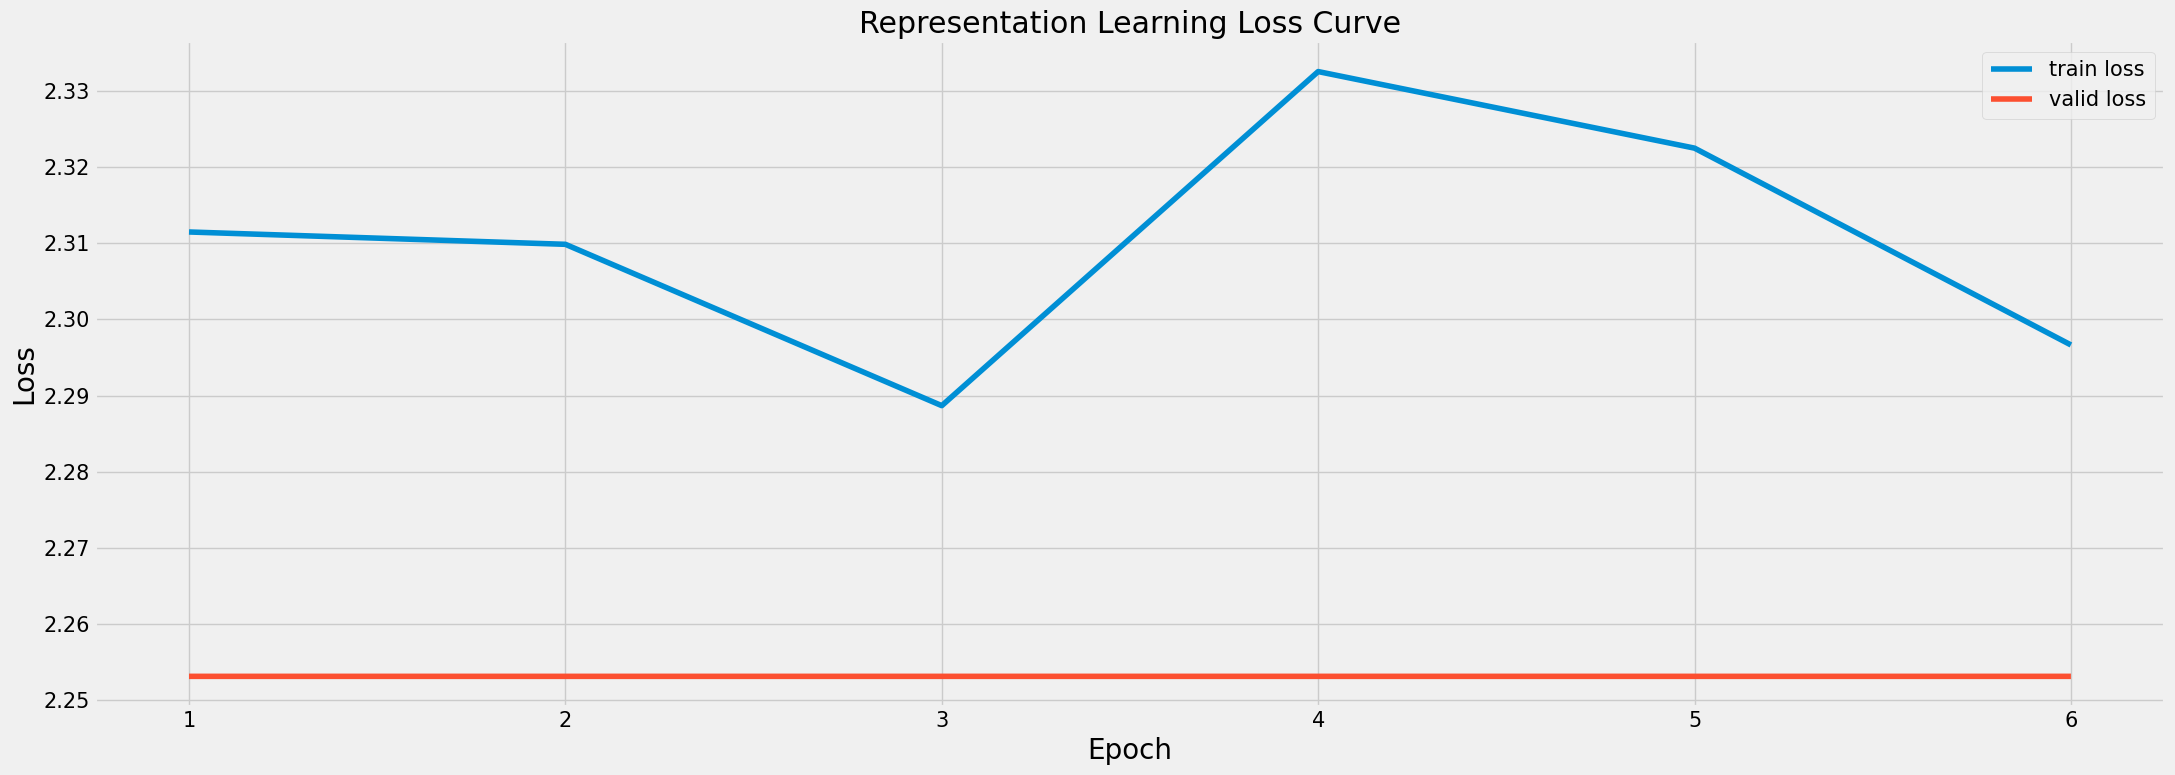

In [26]:
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
plt.rcParams["font.size"] = "15"

fig = plt.figure(figsize=(22, 8))
epochs = list(range(1, len(rep_history["train_loss"]) + 1))

plt.plot(epochs, rep_history["train_loss"], label="train loss")
plt.plot(epochs, rep_history["val_loss"], label="valid loss")
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=20)
plt.legend()
plt.title("Representation Learning Loss Curve")

plt.tight_layout()
plt.show()

In [35]:

# MODEL 2
import torch
import torch.nn as nn
import timm
from torch.optim import lr_scheduler, AdamW
from collections import defaultdict
from time import time
import importlib
import model.ViTrainer

importlib.reload(model.ViTrainer)
from model.ViTrainer import (
    VisionTransformerMLP,
    train_representation,
    train_classifier,
)
import sys

# Stage 2: Classification with Multimodal Fusion
print("Stage 2: Classification with Multimodal Fusion")
criterion_clf = FocalLoss()
optimizer_clf =torch.optim.Adam(vit_model.parameters(), lr=1e-3, weight_decay=1e-5)
# scheduler_clf = lr_scheduler.CosineAnnealingLR(optimizer_clf, T_max=20, eta_min=0)
scheduler_clf = lr_scheduler.StepLR(optimizer_clf, step_size=7, gamma=0.1)

vit_model, clf_history = train_classifier(
    vit_model,
    criterion_clf,
    optimizer_clf,
    scheduler_clf,
    num_epochs=15,
    dataloaders=dataloaders_re,
    device=device,
    save_path="Trained_Models/Vit_Model.pth",
)

# Print training results
print("Training completed.")
print("Representation Learning:")
print(f"Final training loss: {rep_history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {rep_history['val_loss'][-1]:.4f}")
print("Classification:")
print(f"Final training loss: {clf_history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {clf_history['val_loss'][-1]:.4f}")
print(f"Final training accuracy: {clf_history['train_acc'][-1]:.4f}")
print(f"Final validation accuracy: {clf_history['val_acc'][-1]:.4f}")

Stage 2: Classification with Multimodal Fusion
Epoch 1/15
----------
Train Loss: 1.1485 Acc: 0.3812
Val Loss: 0.7345 Acc: 0.4298
Saved best model to best_clf_model2.pth
Epoch 2/15
----------
Train Loss: 0.3722 Acc: 0.5138
Val Loss: 0.5746 Acc: 0.4298
Saved best model to best_clf_model2.pth
Epoch 3/15
----------
Train Loss: 0.2762 Acc: 0.6077
Val Loss: 0.6593 Acc: 0.3884
Epoch 4/15
----------
Train Loss: 0.2401 Acc: 0.6436
Val Loss: 0.9238 Acc: 0.4298
Epoch 5/15
----------
Train Loss: 0.9459 Acc: 0.5470
Val Loss: 2.4714 Acc: 0.3967
Epoch 6/15
----------
Train Loss: 0.4909 Acc: 0.6077
Val Loss: 0.9586 Acc: 0.4380
Epoch 7/15
----------
Train Loss: 0.2476 Acc: 0.6934
Val Loss: 1.4204 Acc: 0.3719
Epoch 8/15
----------
Train Loss: 0.2069 Acc: 0.6851
Val Loss: 1.0387 Acc: 0.3802
Epoch 9/15
----------
Train Loss: 0.1455 Acc: 0.7182
Val Loss: 1.2048 Acc: 0.4380
Epoch 10/15
----------
Train Loss: 0.1029 Acc: 0.7514
Val Loss: 1.1880 Acc: 0.4215
Epoch 11/15
----------
Train Loss: 0.0961 Acc: 0.748

In [19]:
criterion_class = FocalLoss()
criterion_seg = DiceLoss()

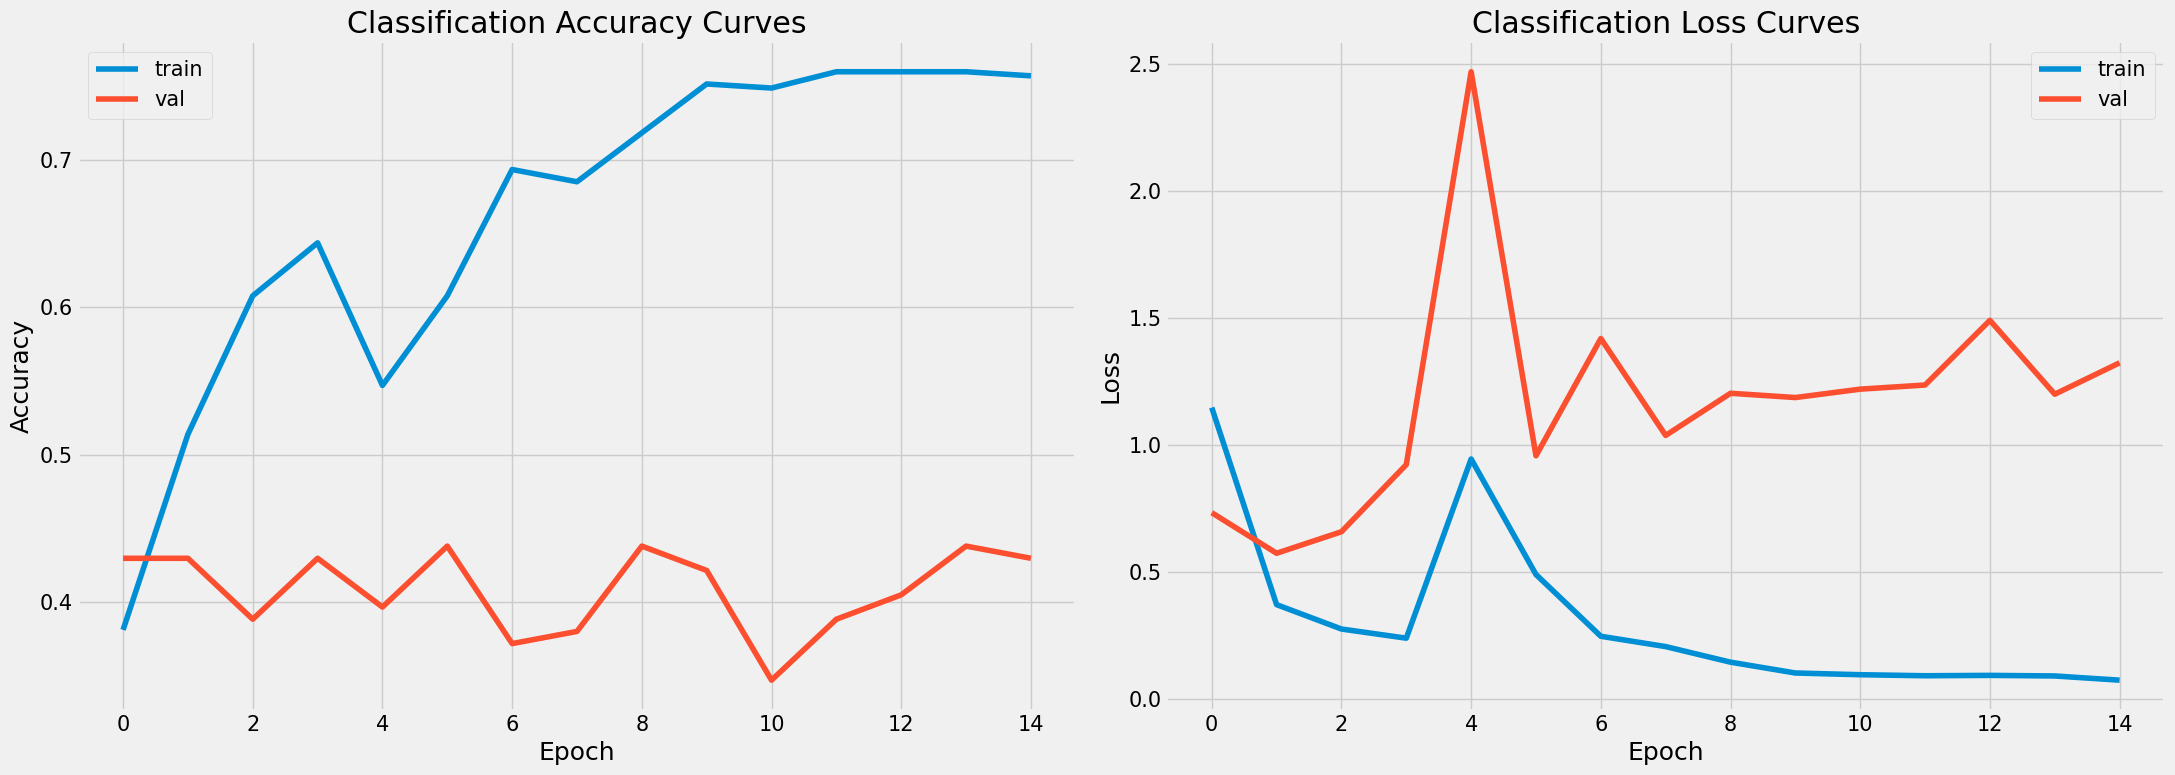

In [37]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def show_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))

    # Accuracy plot
    ax1.plot(history["train_acc"], label="train")
    ax1.plot(history["val_acc"], label="val")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Classification Accuracy Curves")
    ax1.legend()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Loss plot
    ax2.plot(history["train_loss"], label="train")
    ax2.plot(history["val_loss"], label="val")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.set_title("Classification Loss Curves")
    ax2.legend()
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()


show_curves(clf_history)

In [31]:
def test(model, testloader, device):
    model.eval()
    running_accuracy = 0
    total = 0

    with torch.no_grad():
        for images, seg, slope, labels in testloader:
            images = images.float().to(device)
            seg = seg.float().to(device)
            slope = slope.float().to(device)
            labels = labels.to(device)

            outputs = model(images, slope)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            running_accuracy += (predicted == labels).sum().item()

    accuracy = 100 * running_accuracy / total
    print(f"Accuracy of the model based on the test set is: {accuracy:.2f}%")
    return accuracy




In [39]:
def test(model, testloader, device):
    model.eval()
    running_accuracy = 0
    total = 0

    with torch.no_grad():
        for images, seg, slope, labels in testloader:
            images = images.float().to(device)
            seg = seg.float().to(device)
            slope = slope.float().to(device)
            labels = labels.to(device)

            outputs = model(images, slope)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            running_accuracy += (predicted == labels).sum().item()

    accuracy = 100 * running_accuracy / total
    print(f"Accuracy of the model based on the test set is: {accuracy:.2f}%")
    return accuracy

In [40]:
test_accuracy = test(vit_model, testloader, device)

Accuracy of the model based on the test set is: 48.32%
